# Mean & Median Stacking

In [6]:
#importing libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import time

#### Mean Stacking

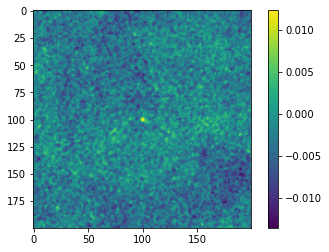

In [2]:
#observing a fits file
filename = './fits_files/image0.fits'
hdulist = fits.open(filename)
data = hdulist[0].data
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

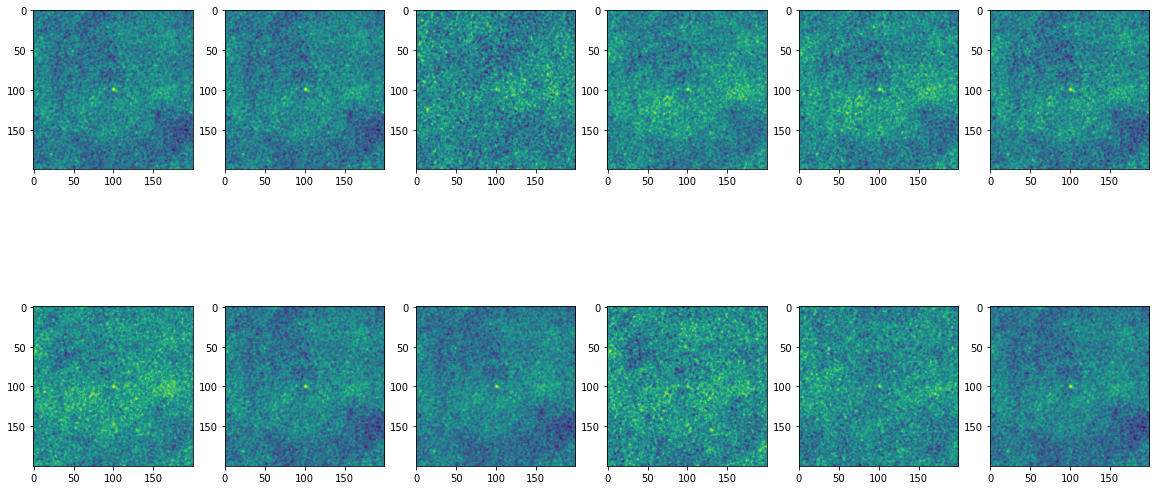

In [3]:
#observing 12 fits files of a pulsar
file_nums = list(range(12))
fig, ax = plt.subplots(2, 6, figsize=(20, 10))
for i in file_nums:
    filename = './fits_files/image' + str(i) + '.fits'
    hdulist = fits.open(filename)
    data = hdulist[0].data
    ax[i//6, i%6].imshow(data.T, cmap=plt.cm.viridis)

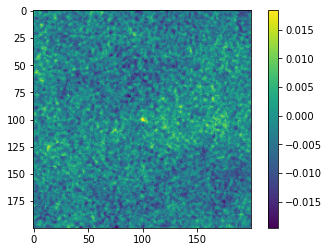

In [4]:
def mean_fits(files):
  length = len(files)
  hdulist = fits.open(files[0])
  data = hdulist[0].data
  hdulist.close()
  for i in range(1, length):
    hdulist = fits.open(files[i])
    data += hdulist[0].data
    hdulist.close()
  return data/length
  
if __name__ == '__main__':
  data  = mean_fits(['./fits_files/image0.fits', './fits_files/image1.fits', './fits_files/image2.fits'])

  plt.imshow(data.T, cmap=plt.cm.viridis)
  plt.colorbar()
  plt.show()

Time takes :  0.040517568588256836
Memory takes :  3750.0


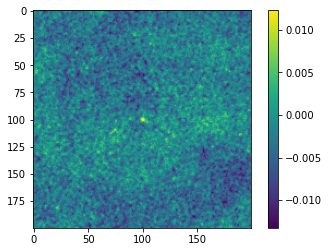

In [10]:
def median_fits(files):
  start = time.time()
  length = len(files)
  my_list = []
  for i in range(length):
    hdulist = fits.open(files[i])
    my_list.append(hdulist[0].data)
    hdulist.close()
    
  my_stack = np.dstack(my_list)
  median = np.median(my_stack, axis=2)
  memory = my_stack.nbytes
  memory /= 1024
  end = time.time()
  t_time = end - start
  return median, t_time, memory

if __name__ == '__main__':
  file_names = list( './fits_files/image' + str(i) + '.fits' for i in range(12))

  result = median_fits(file_names)
  print('Time takes : ', result[1])
  print('Memory takes : ', result[2])
  plt.imshow(result[0].T, cmap=plt.cm.viridis)
  plt.colorbar()
  plt.show()

In [ ]:
#Calculates the running mean and stdev for a list of FITS files using Welford's method
def running_stats(filenames):
  n = 0
  for filename in filenames:
    hdulist = fits.open(filename)
    data = hdulist[0].data
    if n == 0:
      mean = np.zeros_like(data)
      s = np.zeros_like(data)
    n += 1
    delta = data - mean
    mean += delta/n
    s += delta*(data - mean)
    hdulist.close()
  s /= n - 1
  np.sqrt(s, s)
  if n < 2:
    return mean, None
  else:
    return mean, s

def median_bins_fits(my_list, b):
  mean, std = running_stats(my_list)
  dim = mean.shape
  left_bin = np.zeros(dim)
  bins = np.zeros((dim[0], dim[1], b))
  bin_width = (2*std)/b
  for filename in my_list:
    hdulist = fits.open(filename)
    data = hdulist[0].data
    for i in range(dim[0]):
      for j in range(dim[1]):
        value = data[i, j]
        mean_ = mean[i, j]
        std_ = std[i, j]
        if value < mean_ - std_:
          left_bin[i, j] += 1
        elif value >= mean_ - std_ and value < mean_ + std_:
          bin = int((value - (mean_ - std_))/bin_width[i, j])
          bins[i, j, bin] += 1
  return mean, std, left_bin, bins

def median_approx_fits(my_list, b):
  mean, std, left_bin, bins = median_bins_fits(my_list, b)
  dim = mean.shape
  n = len(my_list)
  mid = (n+1)/2
  bin_width = 2*std/b
  median = np.zeros(dim)
  for i in range(dim[0]):
    for j in range(dim[1]):
      count = left_bin[i, j]
      for b_, bincount in enumerate(bins[i, j]):
        count += bincount
        if count >= mid:
          break
      median[i, j] = mean[i, j] - std[i, j] + bin_width[i, j]*(b_ + 0.5)
  return median

if __name__ == '__main__':
  mean, std, left_bin, bins = median_bins_fits(['image0.fits', 'image1.fits', 'image2.fits'], 5)
  median = median_approx_fits(['image0.fits', 'image1.fits', 'image2.fits'], 5)